In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import ttest_ind
import joblib

In [18]:
# Load dataset
def load_data():
    df = pd.read_csv("creditcard.csv")
    return df

In [19]:
# Data Preprocessing
def preprocess_data(df):
    df['normalized_amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
    columns_to_drop = ['Amount']
    if 'Time' in df.columns:
        columns_to_drop.append('Time')
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    return df

In [20]:
# Feature Engineering
def feature_engineering(df):
    df['transaction_frequency'] = df.groupby('V1')['V1'].transform('count')
    return df

In [21]:
# Train Model
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    model.fit(X_train, y_train)
    return model

In [22]:
# Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=1))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve Visualization
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [23]:
# A/B Testing for Fraud Detection Policy Optimization
def ab_testing(y_control, y_test):
    t_stat, p_value = ttest_ind(y_control, y_test, equal_var=False)
    print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
    if p_value < 0.05:
        print("Significant difference found between the control and test fraud policies.")
    else:
        print("No significant difference found.")

In [24]:
# Function to make predictions
def make_prediction(model, features, feature_names):
    features_df = pd.DataFrame([features], columns=feature_names)
    prediction = model.predict(features_df)
    return int(prediction[0])

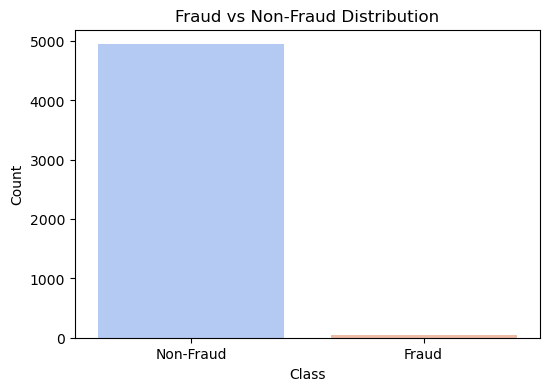

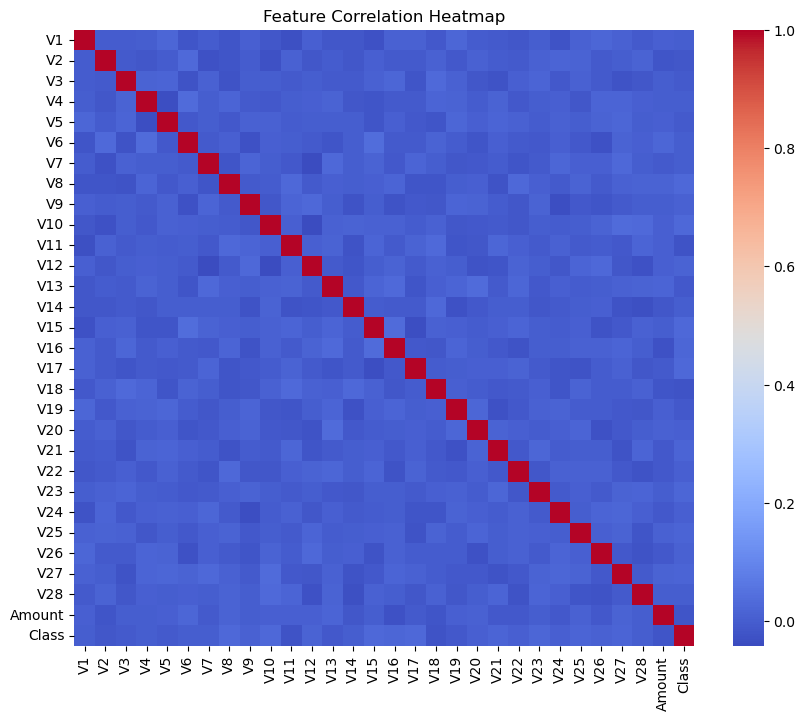

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       984
           1       1.00      0.00      0.00        16

    accuracy                           0.98      1000
   macro avg       0.99      0.50      0.50      1000
weighted avg       0.98      0.98      0.98      1000

ROC AUC Score: 0.47989710365853655


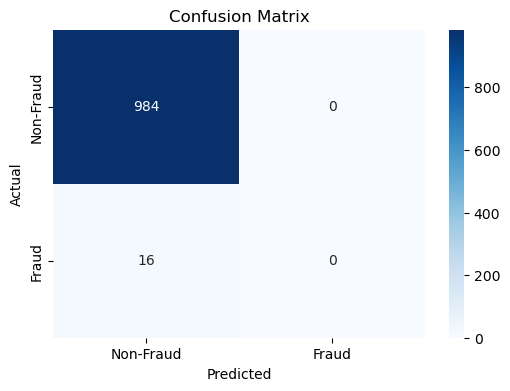

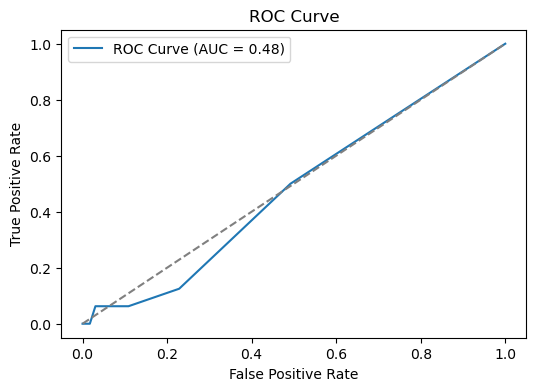

T-Statistic: 3.7662427137000853, P-Value: 0.00017540315956816177
Significant difference found between the control and test fraud policies.
Sample Fraud Prediction: 0


In [25]:
if __name__ == '__main__':
    df = load_data()
    
    # Fraud vs. Non-Fraud Distribution
    plt.figure(figsize=(6,4))
    sns.countplot(x='Class', hue='Class', data=df, palette='coolwarm', legend=False)
    plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
    plt.title('Fraud vs Non-Fraud Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    
    # Feature Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.show()
    
    df = preprocess_data(df)
    df = feature_engineering(df)
    
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    
    joblib.dump(model, "fraud_model.pkl")
    
    # Simulate A/B Testing
    y_control = np.random.choice([0, 1], size=len(y_test), p=[0.98, 0.02])  # Simulated old policy
    y_test_pred = model.predict(X_test)  # New policy predictions
    ab_testing(y_control, y_test_pred)
    
    # Load and test the model
    loaded_model = joblib.load("fraud_model.pkl")
    sample_features = X_test.iloc[0].tolist()
    feature_names = X_train.columns.tolist()
    print("Sample Fraud Prediction:", make_prediction(loaded_model, sample_features, feature_names))